## GENERAL SETUP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.planets import PlanetModel
from gallifrey.utilities.dataframe import rename_labels
from gallifrey.visualization.seaborn import (
    set_plot_defaults,
    get_palette,
    SeabornFigure,
)

## PLOT SETUP

In [18]:
print(
    "Plan now: See if you can remove inner_radius and photoevap rate from parameter. Do this by making two models, one with all parameter and one with only the 2 remaining and compare outputs. First thing to do is implement using fewer variables in the model"
)

Plan now: See if you can remove inner_radius and photoevap rate from parameter. Do this by making two models, one with all parameter and one with only the 2 remaining and compare outputs. First thing to do is implement using fewer variables in the model


In [19]:
print(
    "what do you want from pairplot, what you see on diagonal is somewhat a representation of parameter distributions rather than the mapping of parameter to number of planets"
)
print("CHANGES WITH MASS (NUMBER OF PLANETS, CHANGES IN CORRELATIONS)")
print(
    "plot number of planets (of every category) as function of photoevaporation rate/inner disk radius to see if there really is no effect"
)

what do you want from pairplot, what you see on diagonal is somewhat a representation of parameter distributions rather than the mapping of parameter to number of planets
CHANGES WITH MASS (NUMBER OF PLANETS, CHANGES IN CORRELATIONS)
plot number of planets (of every category) as function of photoevaporation rate/inner disk radius to see if there really is no effect


In [20]:
set_plot_defaults()

## ORIGINAL SAMPLE (HOST STAR MASS = 1)

### Setup Variables and Planet Model

In [21]:
figure_directory = "Original_NGPPS_sample"

num_embryos = 50
host_star_mass = 1
age = int(1e8)

planet_model = PlanetModel(num_embryos)

population_id = planet_model.get_population_id(num_embryos, host_star_mass)

categories = [
    category
    for category in planet_model.categories
    if category not in ["Dwarf", "D-Burner"]
]

### Recreate Original Sample (needs neighbors=1, to actually re-create original data)

In [22]:
original_variables = planet_model.get_systems(population_id).variables
original_variables["age"] = age
original_sample = planet_model.prediction(
    categories,
    host_star_mass,
    variables=original_variables,
    return_full=True,
    neighbors=1,
)

# change labels for plotting
original_sample, labels = rename_labels(original_sample)

### Pair Plot (variations for one planet category with variables)

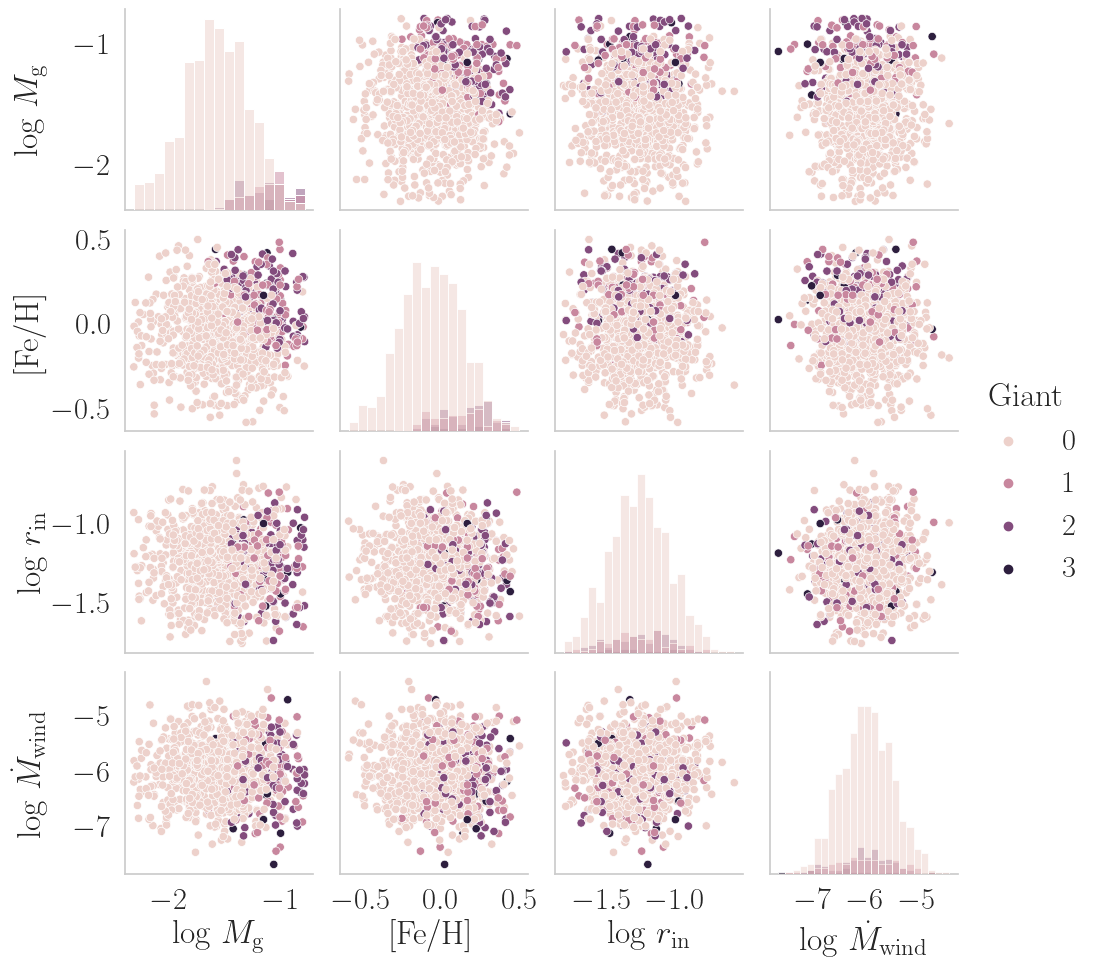

In [23]:
planet_type = "Giant"
pair_plot = sns.pairplot(
    original_sample.drop(columns=["age", *[c for c in categories if c != planet_type]]),
    hue=planet_type,
    diag_kind="hist",
    palette=get_palette(n_colors=4),
)
SeabornFigure(pair_plot).save("pairplot.pdf", sub_directory=figure_directory)

### Correlation plot between Planet Types and Variables (Kendall Tau correlation coefficent)

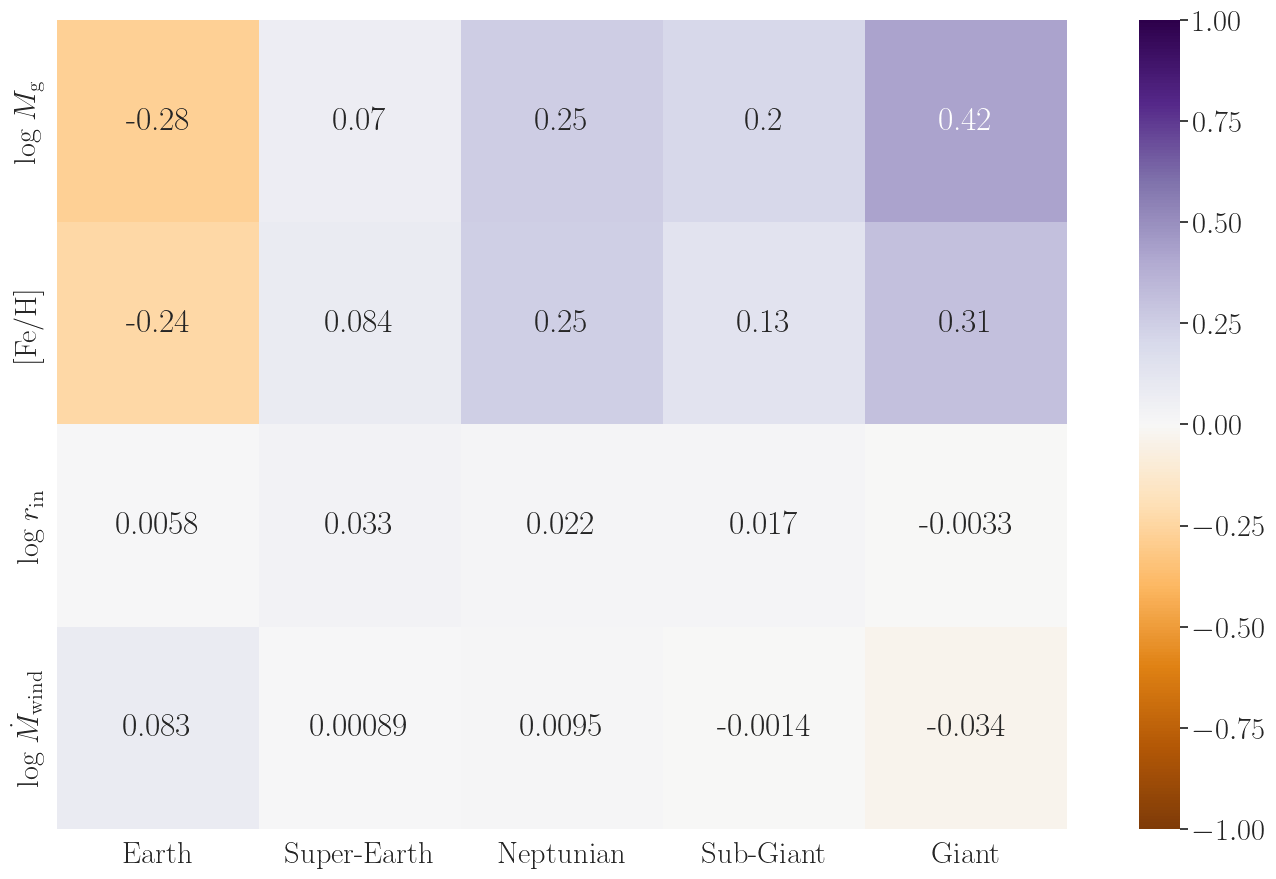

In [24]:
correlation_matrix = original_sample.corr(method="kendall").drop(
    columns=["age", *labels], index=["age", *categories]
)
correlation_plot = sns.heatmap(
    correlation_matrix, vmin=-1, vmax=1, square=True, annot=True, cmap="PuOr"
)
SeabornFigure(correlation_plot).save(
    "correlation_matrix.pdf", sub_directory=figure_directory
)

### Changes of Number of Planets With Initial Embryo Count

In [25]:
num_embryo_list = [10, 20, 50, 100]

results_embryos = {}
for num in num_embryo_list:
    planet_model = PlanetModel(num)
    results_embryos[num] = planet_model.prediction(
        categories,
        host_star_mass,
        variables=original_variables,
        return_full=False,
        neighbors=1,
    ).sum()

results_embryos = pd.DataFrame(results_embryos).T
results_embryos = results_embryos.reset_index().rename(
    {"index": "Number of Embryos"}, axis="columns"
)

results_embryos_long_format = results_embryos.melt(
    id_vars="Number of Embryos",
    var_name="Category",
    value_name="Total Number",
)

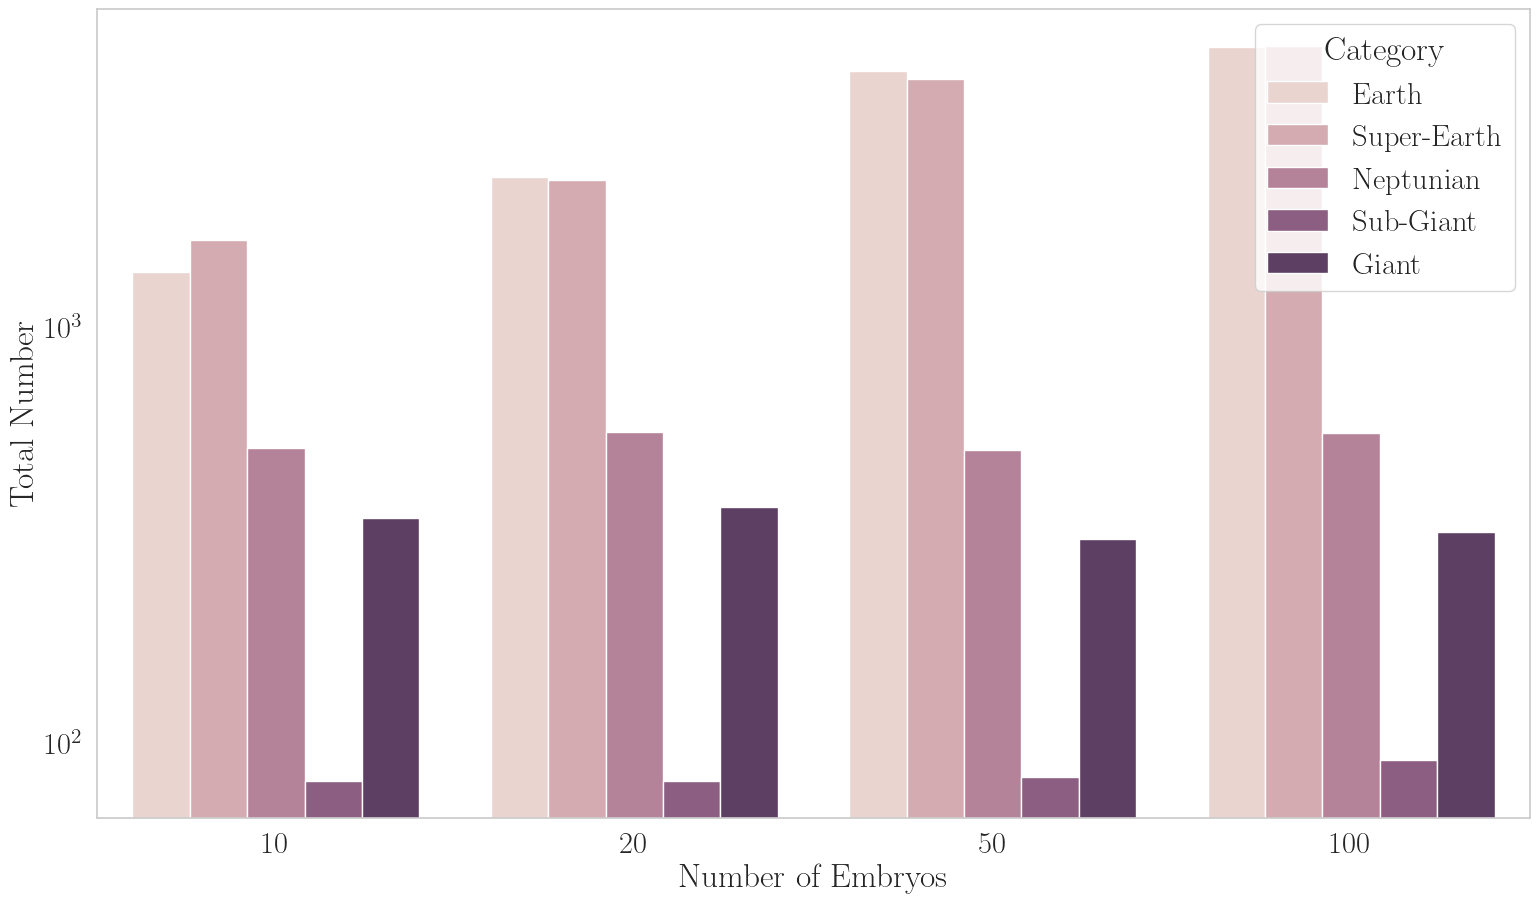

In [26]:
embryo_barplot = sns.barplot(
    x="Number of Embryos",
    y="Total Number",
    hue="Category",
    data=results_embryos_long_format,
    log=True,
    palette=get_palette(),
)
SeabornFigure(embryo_barplot).save(
    "number_of_embryos.pdf", sub_directory=figure_directory
)

### Changes of Number of Planets With Host Star Mass

In [27]:
host_star_mass_list = [0.1, 0.3, 0.5, 0.7, 1]
planet_model = PlanetModel(num_embryos)

results_stellar_mass = {}
for mass in host_star_mass_list:
    results_stellar_mass[mass] = planet_model.prediction(
        categories,
        mass,
        variables=original_variables,
        return_full=False,
        neighbors=1,
    ).sum()

results_stellar_mass = pd.DataFrame(results_stellar_mass).T
results_stellar_mass = results_stellar_mass.reset_index().rename(
    {"index": r"Host Star Mass [$M_\odot$]"}, axis="columns"
)

results_stellar_mass_long_format = results_stellar_mass.melt(
    id_vars=r"Host Star Mass [$M_\odot$]",
    var_name="Category",
    value_name="Total Number",
)

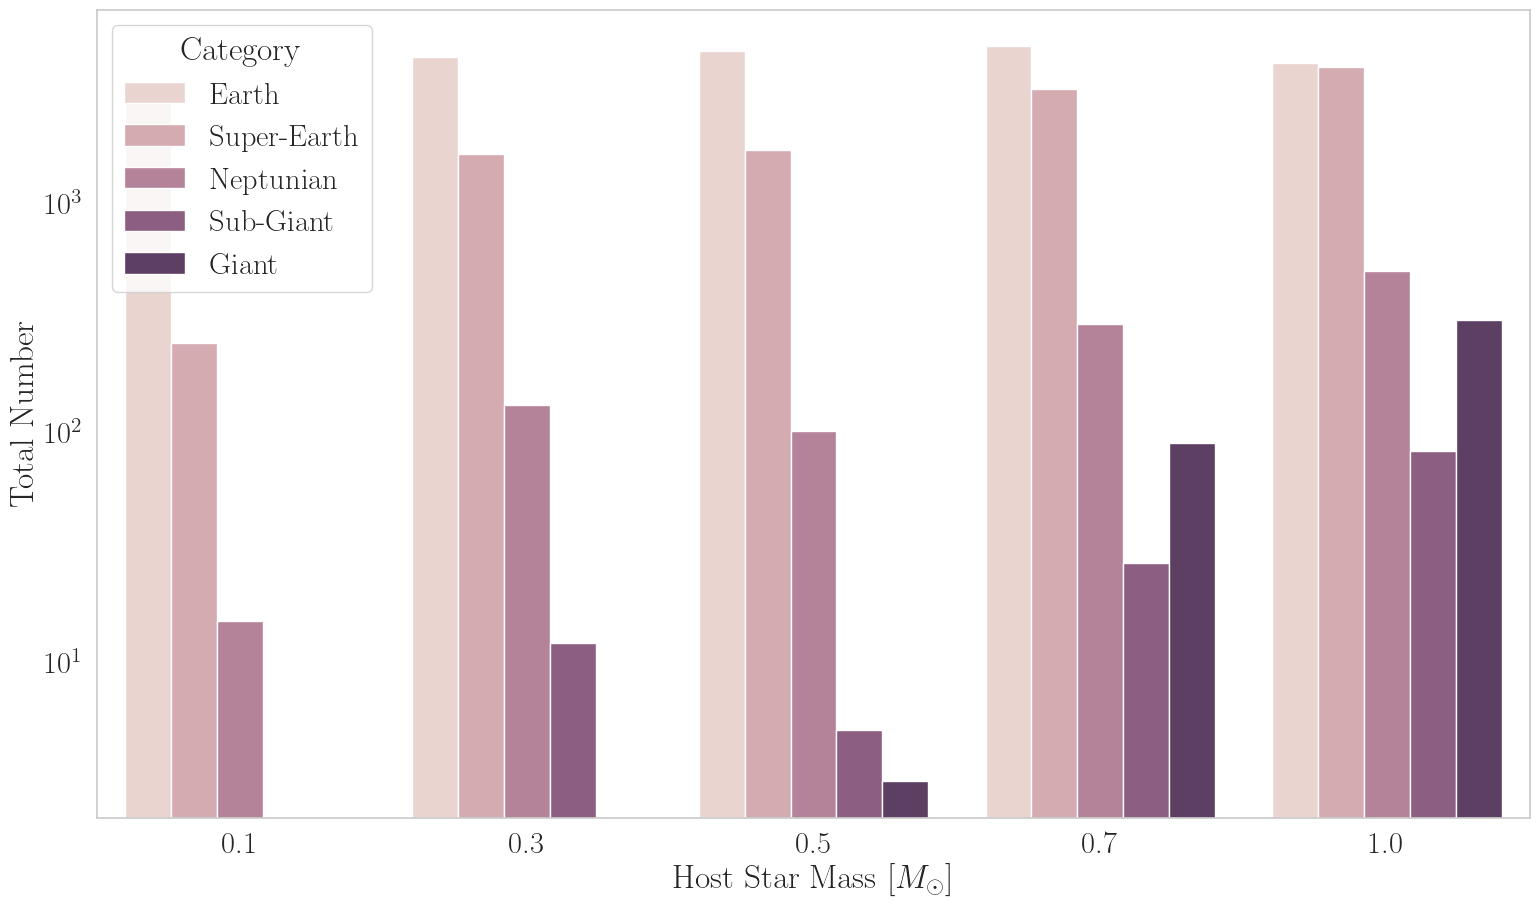

In [28]:
host_star_mass_plot = sns.barplot(
    x=r"Host Star Mass [$M_\odot$]",
    y="Total Number",
    hue="Category",
    data=results_stellar_mass_long_format,
    log=True,
    palette=get_palette(),
)
SeabornFigure(host_star_mass_plot).save(
    "host_star_mass.pdf", sub_directory=figure_directory
)

## TESTING AROUND

In [32]:
print("reducing dimensionality, see if this actually functions properly")
print(
    "what to do then: create sample of 10000 log_inital_mass and [Fe/H] values, predict once with model that includes all parameter and once with model that only contains 2 parameter and see "
    "if that gives same results "
)

original_variables = planet_model.get_systems(population_id).variables
original_variables["age"] = age
original_variables = original_variables.drop(
    columns=["log_inner_edge", "log_photoevaporation"]
)
original_sample = planet_model.prediction(
    categories,
    host_star_mass,
    variables=original_variables,
    included_variables=("log_initial_mass", "[Fe/H]"),
    return_full=True,
    neighbors=1,
)

original_sample

reducing dimensionality, see if this actually functions properly
what to do then: create sample of 10000 log_inital_mass and [Fe/H] values, predict once with model that includes all parameter and once with model that only contains 2 parameter and see if that gives same results 


,log_initial_mass,[Fe/H],age,Earth,Super-Earth,Neptunian,Sub-Giant,Giant
0,-1.355451,-0.210615,100000000,5,13,0,0,0
1,-1.823941,-0.131265,100000000,6,1,0,0,0
2,-2.067688,0.026333,100000000,5,2,0,0,0
3,-0.809599,-0.020964,100000000,0,0,0,0,1
4,-2.231309,0.051618,100000000,4,0,0,0,0
...,...,...,...,...,...,...,...,...
995,-0.859219,-0.111029,100000000,1,0,2,1,1
996,-1.344220,0.278930,100000000,0,0,0,0,2
997,-2.065557,-0.245970,100000000,2,0,0,0,0
998,-1.364114,-0.216271,100000000,10,6,0,0,0
